In [1]:
import pandas as pd
import numpy as np
train_raw_data = pd.read_json("../Twibot-20/Twibot-20/train.json")
#train_raw_data = train_raw_data.drop(['tweet'], axis=1)

train_raw_data.head()
probe_date = pd.to_datetime('2020-09-06', utc=True)
print(probe_date)

2020-09-06 00:00:00+00:00


In [2]:
train_profile = pd.DataFrame([profile for profile in train_raw_data.profile])

train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = train_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

train_profile.set_index('id', inplace=True)

#Douteux
train_profile = train_profile.replace([0], 1)


train_labels = train_raw_data["label"].values
train_dict = {"statuses_count":train_profile.statuses_count, 
                "followers_count":train_profile.followers_count, 
                "friends_count":train_profile.friends_count, 
                "favourites_count":train_profile.favourites_count, 
                "listed_count":train_profile.listed_count, 
                "default_profile":train_profile.default_profile,
                "profile_use_background_image":train_profile.profile_use_background_image,
                "verified":train_profile.verified,
                "user_age":(probe_date - pd.to_datetime(train_profile.created_at)).dt.days,
                "tweet_freq": np.nan_to_num(train_profile.statuses_count / (probe_date - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_growth_rate": np.nan_to_num(train_profile.followers_count / (probe_date - pd.to_datetime(train_profile.created_at)).dt.days),
                "friends_growth_rate" : np.nan_to_num(train_profile.friends_count / (probe_date - pd.to_datetime(train_profile.created_at)).dt.days),
                "favourites_growth_rate" : np.nan_to_num(train_profile.favourites_count / (probe_date - pd.to_datetime(train_profile.created_at)).dt.days),
                "listed_growth_rate" : np.nan_to_num(train_profile.listed_count / (probe_date - pd.to_datetime(train_profile.created_at)).dt.days),
                "followers_friends_ratio" : np.nan_to_num(train_profile.followers_count / train_profile.friends_count),
                "screen_name_length": train_profile.screen_name.str.len(),
                "num_digits_in_screen_name": train_profile.screen_name.str.count('\d'),
                "name_length": train_profile.name.str.len(),
                "num_digits_in_name": train_profile.name.str.count('\d'),
                "description_length": train_profile.description.str.len(),
                 "label":train_labels
               }
train_features = pd.DataFrame(data=train_dict)
train_features = train_features.replace({'True': True, 'False': False})
train_features.fillna(0)

train_features.describe()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,user_age,tweet_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,name_length,num_digits_in_name,description_length,label
count,8.278000e+03,8.278000e+03,8.278000e+03,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000,8.278000e+03,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000,8278.000000
mean,2.158684e+04,6.464586e+05,6.609924e+03,13297.515100,1504.744262,2581.310461,8.276511,184.910579,3.368382,8.136530,0.396479,4.483242e+04,12.139889,0.764557,14.057381,0.104011,83.044214,0.561247
std,9.008917e+04,4.148888e+06,6.377856e+04,40415.669701,9855.033473,1423.596291,27.756118,1076.876131,20.468369,27.560025,2.322571,1.356607e+06,2.710466,1.756609,6.125798,0.596134,55.983338,0.496265
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,0.000239,0.000254,0.000202,0.000205,0.000217,1.034661e-03,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000
25%,4.050000e+02,2.010000e+02,2.310000e+02,146.000000,1.000000,1335.000000,0.289851,0.131924,0.119376,0.095520,0.001410,3.494753e-01,10.000000,0.000000,11.000000,0.000000,30.000000,0.000000
50%,3.624000e+03,1.939500e+03,7.230000e+02,1584.500000,13.000000,2885.000000,1.612506,1.049092,0.348204,0.773529,0.009496,1.063065e+00,12.000000,0.000000,14.000000,0.000000,86.000000,1.000000
75%,1.572975e+04,3.762050e+04,2.124000e+03,9121.250000,258.000000,3875.000000,6.271325,15.579376,1.252045,4.408160,0.100146,3.232864e+01,14.000000,1.000000,17.000000,0.000000,138.000000,1.000000
max,5.140025e+06,1.124032e+08,4.339982e+06,783456.000000,550181.000000,5282.000000,1296.349306,26897.141900,1044.520337,541.424710,131.653745,8.703181e+07,16.000000,13.000000,51.000000,10.000000,202.000000,1.000000


In [5]:
import pandas as pd
test_raw_data = pd.read_json("../Twibot-20/Twibot-20/test.json")
test_raw_data = test_raw_data.drop(['tweet'], axis=1)

test_raw_data.head()

,ID,profile,neighbor,domain,label
0,1188812492010487808,"{'id': '1188812492010487808 ', 'id_str': '1188...",None,"[Politics, Sports]",1
1,155659213,"{'id': '155659213 ', 'id_str': '155659213 ', '...",None,"[Politics, Business, Entertainment, Sports]",0
2,147725246,"{'id': '147725246 ', 'id_str': '147725246 ', '...","{'following': ['36734275', '20713061', '755419...",[Politics],0
3,1296248637194895360,"{'id': '1296248637194895360 ', 'id_str': '1296...","{'following': ['87818409', '41390292', '140910...",[Politics],1
4,1339835893,"{'id': '1339835893 ', 'id_str': '1339835893 ',...",None,"[Politics, Business, Entertainment, Sports]",0


In [6]:
test_profile = pd.DataFrame([profile for profile in test_raw_data.profile])

test_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]] = test_profile[["statuses_count","followers_count","friends_count","favourites_count","listed_count"]].apply(pd.to_numeric, errors='coerce', axis=1)

test_profile.set_index('id', inplace=True)

#Douteux
test_profile = test_profile.replace([0], 1)


test_labels = test_raw_data["label"].values
test_dict = {"statuses_count":test_profile.statuses_count, 
                "followers_count":test_profile.followers_count, 
                "friends_count":test_profile.friends_count, 
                "favourites_count":test_profile.favourites_count, 
                "listed_count":test_profile.listed_count, 
                "default_profile":test_profile.default_profile,
                "profile_use_background_image":test_profile.profile_use_background_image,
                "verified":test_profile.verified,
                "user_age":(probe_date - pd.to_datetime(test_profile.created_at)).dt.days,
                "tweet_freq": np.nan_to_num(test_profile.statuses_count / (probe_date - pd.to_datetime(test_profile.created_at)).dt.days),
                "followers_growth_rate": np.nan_to_num(test_profile.followers_count / (probe_date - pd.to_datetime(test_profile.created_at)).dt.days),
                "friends_growth_rate" : np.nan_to_num(test_profile.friends_count / (probe_date - pd.to_datetime(test_profile.created_at)).dt.days),
                "favourites_growth_rate" : np.nan_to_num(test_profile.favourites_count / (probe_date - pd.to_datetime(test_profile.created_at)).dt.days),
                "listed_growth_rate" : np.nan_to_num(test_profile.listed_count / (probe_date - pd.to_datetime(test_profile.created_at)).dt.days),
                "followers_friends_ratio" : np.nan_to_num(test_profile.followers_count / test_profile.friends_count),
                "screen_name_length": test_profile.screen_name.str.len(),
                "num_digits_in_screen_name": test_profile.screen_name.str.count('\d'),
                "name_length": test_profile.name.str.len(),
                "num_digits_in_name": test_profile.name.str.count('\d'),
                "description_length": test_profile.description.str.len(),
                 "label":test_labels
               }
test_features = pd.DataFrame(data=test_dict)
test_features = test_features.replace({'True': True, 'False': False})
test_features.fillna(0)

test_features.describe()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,user_age,tweet_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,name_length,num_digits_in_name,description_length,label
count,1183.000000,1.183000e+03,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1.183000e+03,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000
mean,21437.885883,8.231450e+05,6449.630600,12514.671175,1865.143702,2617.882502,8.248606,230.839999,3.446320,7.292009,0.486439,2.425472e+04,12.238377,0.775148,13.935757,0.116653,80.585799,0.540997
std,57544.172703,5.577725e+06,40365.822872,29729.379627,9400.101349,1426.378346,22.159686,1470.127290,15.526549,25.443775,2.316623,3.385352e+05,2.647793,1.755386,6.040691,0.571386,55.767169,0.498527
min,1.000000,1.000000e+00,1.000000,1.000000,1.000000,2.000000,0.000554,0.000479,0.000206,0.000203,0.000223,1.724881e-03,4.000000,0.000000,2.000000,0.000000,1.000000,0.000000
25%,381.000000,2.145000e+02,234.500000,159.500000,1.000000,1393.000000,0.268793,0.143255,0.122961,0.098144,0.001410,3.661909e-01,10.000000,0.000000,10.000000,0.000000,26.500000,0.000000
50%,4051.000000,2.574000e+03,748.000000,1884.000000,17.000000,2931.000000,1.693602,1.299953,0.342584,0.941322,0.011106,1.149573e+00,12.000000,0.000000,13.000000,0.000000,80.000000,1.000000
75%,19556.000000,4.764750e+04,2051.500000,10001.000000,331.500000,3921.000000,6.786687,17.980579,1.130236,4.308746,0.114213,3.945276e+01,14.000000,1.000000,16.000000,0.000000,135.000000,1.000000
max,859809.000000,8.731376e+07,804528.000000,322238.000000,118656.000000,4973.000000,450.740741,23370.922109,340.901695,662.925926,28.325615,1.045909e+07,16.000000,12.000000,49.000000,5.000000,169.000000,1.000000


In [8]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

Y_train = train_features['label']
X_train = train_features.drop(['label'], axis=1)

Y_test = test_features['label']
X_test = test_features.drop(['label'], axis=1)
# Split dataset into training set and test set

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1183 entries, 1188812492010487808  to 3385331674 
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   statuses_count                1183 non-null   int64  
 1   followers_count               1183 non-null   int64  
 2   friends_count                 1183 non-null   int64  
 3   favourites_count              1183 non-null   int64  
 4   listed_count                  1183 non-null   int64  
 5   default_profile               1183 non-null   bool   
 6   profile_use_background_image  1183 non-null   bool   
 7   verified                      1183 non-null   bool   
 8   user_age                      1183 non-null   int64  
 9   tweet_freq                    1183 non-null   float64
 10  followers_growth_rate         1183 non-null   float64
 11  friends_growth_rate           1183 non-null   float64
 12  favourites_growth_rate        1183 non-nu

In [9]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)

clf.fit(X_train.values,Y_train.values)

y_pred=clf.predict(X_test.values)

In [10]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.8072696534234995


In [11]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

verified                        0.220270
followers_friends_ratio         0.086695
followers_count                 0.075846
listed_growth_rate              0.070237
followers_growth_rate           0.063621
listed_count                    0.061604
user_age                        0.046126
friends_growth_rate             0.045643
friends_count                   0.044977
statuses_count                  0.043453
tweet_freq                      0.043435
favourites_growth_rate          0.040924
description_length              0.040580
favourites_count                0.037750
name_length                     0.030554
screen_name_length              0.024192
num_digits_in_screen_name       0.012328
default_profile                 0.005767
profile_use_background_image    0.003092
num_digits_in_name              0.002906
dtype: float64

No handles with labels found to put in legend.


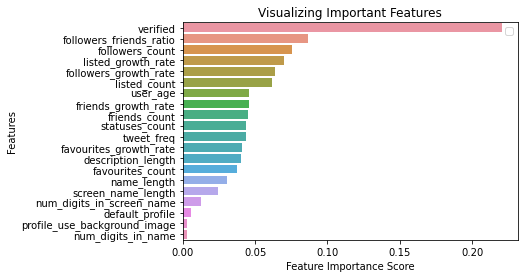

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [35]:
profiles = [profile for profile in train_raw_data[train_raw_data["label"] == 0].sample(n=30)["profile"]]
for profile in profiles:
    print("https://twitter.com/"+str(profile['screen_name'])+"\n")

https://twitter.com/aeonmag 

https://twitter.com/iRuntown 

https://twitter.com/infiltradoxxx 

https://twitter.com/JonGordon11 

https://twitter.com/JoeBiden 

https://twitter.com/Klaustin15 

https://twitter.com/tom_sfc_ 

https://twitter.com/USTreasury 

https://twitter.com/lainehendersonn 

https://twitter.com/eugemigliori 

https://twitter.com/rjalon 

https://twitter.com/EmeraldRobinson 

https://twitter.com/techecoled 

https://twitter.com/virsanghvi 

https://twitter.com/IDAIRELAND 

https://twitter.com/Andrews_JBA 

https://twitter.com/CoachLesMiles 

https://twitter.com/Ry1faz 

https://twitter.com/EmmaWatson 

https://twitter.com/Childofthelordt 

https://twitter.com/Autret11 

https://twitter.com/MeganAlexander 

https://twitter.com/EricTrump 

https://twitter.com/MissCoppock 

https://twitter.com/YesiKenn 

https://twitter.com/avharris 

https://twitter.com/tpwkxwalls 

https://twitter.com/Morgangibbs27 

https://twitter.com/Queen_UK 

https://twitter.com/UNICEFInnocenti 

[{'id': '821912337711927296 ', 'id_str': '821912337711927296 ', 'name': 'Renee Martin 🌹 ', 'screen_name': 'rpm_martin ', 'location': ' ', 'profile_location': 'None ', 'description': ' ', 'url': 'None ', 'entities': "{'description': {'urls': []}} ", 'protected': 'False', 'followers_count': '46 ', 'friends_count': '564 ', 'listed_count': '0 ', 'created_at': 'Thu Jan 19 02:49:06 +0000 2017 ', 'favourites_count': '6422 ', 'utc_offset': 'None ', 'time_zone': 'None ', 'geo_enabled': 'False', 'verified': 'False', 'statuses_count': '2519 ', 'lang': 'None ', 'contributors_enabled': 'False', 'is_translator': 'False', 'is_translation_enabled': 'False', 'profile_background_color': 'F5F8FA ', 'profile_background_image_url': 'None ', 'profile_background_image_url_https': 'None ', 'profile_background_tile': 'False', 'profile_image_url': 'http://pbs.twimg.com/profile_images/1268187126492880898/JlVJ3N5w_normal.jpg ', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1268187126492880898/J